In [10]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from category_encoders import BinaryEncoder, TargetEncoder
from sklearn.feature_extraction import FeatureHasher
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score

In [ ]:
ratings = pd.read_csv('../../datasets/ml-100k/u.user', 
                      sep='\t', 
                      names=['user_id', 'item_id', 'rating', 'timestamp'])
ratings = ratings.drop(columns='timestamp')

user_item_dense = ratings.pivot(
    index='user_id',
    columns='item_id',
    values='rating'
).fillna(0)

In [12]:
user = pd.read_csv('../datasets/ml-100k/u.user', 
                      sep='|', 
                      names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])

merged = user.merge(user_item_dense, on='user_id')

user

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


In [13]:
#  One-Hot Encoding sulle colonne categoriche
user_encoded = pd.get_dummies(merged, columns=['gender', 'occupation', 'zip_code'])
X = user_encoded.drop(columns=['user_id'])
X.columns = X.columns.astype(str)

In [14]:
#LABEL ENCODER

le_gender = LabelEncoder()
le_occ = LabelEncoder()
le_zip = LabelEncoder()
user['gender_le'] = le_gender.fit_transform(user['gender'])
user['occupation_le'] = le_occ.fit_transform(user['occupation'])
user['zip_le'] = le_zip.fit_transform(user['zip_code'])
df_le = user[['age','gender_le','occupation_le', 'zip_le']]
#df_le

In [15]:
#BINARY ENCODER
be = BinaryEncoder(cols=['gender','occupation','zip_code'], return_df=True)
df_be = be.fit_transform(user[['age', 'gender','occupation','zip_code']])
#df_be

In [16]:
#HASHER 
user_dicts = user[['gender', 'occupation', 'zip_code']].astype(str).to_dict(orient='records')

# 2. Hasher con input_type='dict'
hasher = FeatureHasher(n_features=10, input_type='dict')
hashed = hasher.transform(user_dicts)

# 3. Converti in DataFrame
#df_hash = pd.DataFrame(hashed.toarray(), columns=[f"hash_{i}" for i in range(10)])

In [17]:
#TARGET ENCODER

te = TargetEncoder(cols=['gender', 'occupation', 'zip_code'])
df_te = te.fit_transform(user[['gender', 'occupation', 'zip_code']], user['age'])
df_te['age'] = user['age']
#df_te

In [18]:
# 4. Standardizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [19]:
# 6. Trova numero ottimale di cluster via Silhouette Score
sil_scores = []
K_range = range(2, 11)
for k in K_range:
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = agg.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

optimal_k = K_range[sil_scores.index(max(sil_scores))]
print(f"Numero ottimale di cluster: {optimal_k}")

Numero ottimale di cluster: 2


In [20]:
opt = sil_scores.index(max(sil_scores))
sil_scores[opt]

0.22032825283895188

In [21]:
sil_scores

[0.22032825283895188,
 0.21248664871982686,
 0.21300695007579473,
 0.21413465781370036,
 0.21199234409838955,
 0.21164422309319583,
 0.21258818448801373,
 0.20894583948677084,
 0.20477745403754988]

In [22]:
# 7. Applica AgglomerativeClustering
agg_final = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
user['cluster'] = agg_final.fit_predict(X_scaled)

In [23]:
pca = PCA(n_components=3)
components = pca.fit_transform(X_scaled)
user[['PCA1','PCA2','PCA3']] = components

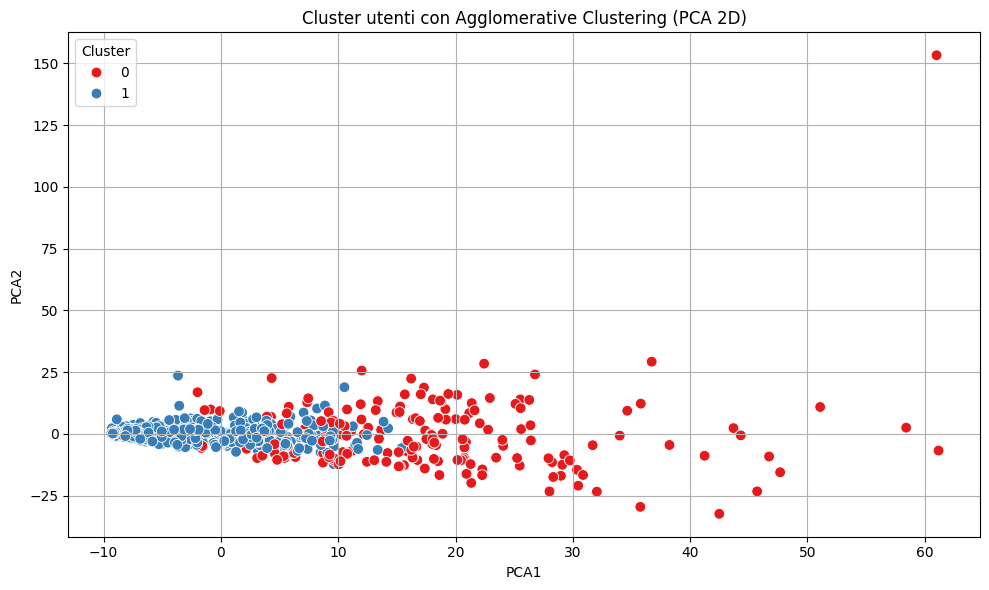

In [24]:
# 9. Plot dei cluster
plt.figure(figsize=(10,6))
sns.scatterplot(data=user, x='PCA1', y='PCA2', hue='cluster', palette='Set1', s=60)
plt.title('Cluster utenti con Agglomerative Clustering (PCA 2D)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
import plotly.express as px


fig = px.scatter_3d(
    user,
    x='PCA1',
    y='PCA2',
    z='PCA3',
    color='cluster',
    title='Cluster utenti con K-Means (PCA 3D)',
    labels={'PCA1': 'PCA1', 'PCA2': 'PCA2', 'PCA3': 'PCA3'}
)

fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=40),
    legend_title_text='Cluster'
)

fig.show()
